In [1]:
import torch
from divide_images import test_train
from dataloader import create_dataloader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from model import Network
import torch.optim as optim
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torch_mtcnn import detect_faces
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

/home/pratik/Documents/dev_v_super/Project1/myvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## Splitting the mask dataset

In [2]:
src_folder = "./data/"
test_path = "./test_data/"
train_path = "./train_data/"
sanity_path = './sanity_data/'

In [3]:
test_train(src_folder, test_path, train_path)

## Creating Data Loader

In [4]:
train_loader = create_dataloader(train_path, batch_size = 4)
test_loader = create_dataloader(test_path, batch_size = 4)
sanity_loader = create_dataloader(sanity_path, batch_size = 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


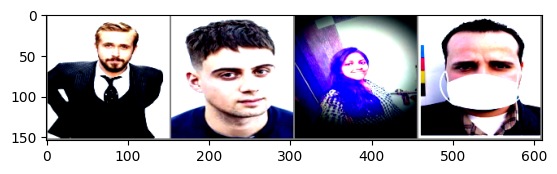

tensor([1, 1, 1, 0])
no_mask no_mask no_mask mask 


In [5]:
classes = ('mask','no_mask')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(labels)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [6]:
labels

tensor([1, 1, 1, 0])

In [7]:
net = Network()
print(net)

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=20736, out_features=128, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Li

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [9]:
net.train()
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.545


/home/pratik/Documents/dev_v_super/Project1/myvenv/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[1,   400] loss: 0.335
[1,   600] loss: 0.344
[1,   800] loss: 0.308
[1,  1000] loss: 0.297
[1,  1200] loss: 0.289
[1,  1400] loss: 0.281
[1,  1600] loss: 0.257
[2,   200] loss: 0.234
[2,   400] loss: 0.253
[2,   600] loss: 0.245
[2,   800] loss: 0.231
[2,  1000] loss: 0.220
[2,  1200] loss: 0.234
[2,  1400] loss: 0.243
[2,  1600] loss: 0.216
Finished Training


In [10]:
net.eval()
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 92 %


In [11]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: mask  is 92.8 %
Accuracy for class: no_mask is 91.6 %


### Testing Single Images

In [12]:
mask_image_path = './data/with_mask/with_mask_1001.jpg'
no_mask_image_path = './data/without_mask/without_mask_100.jpg'

In [13]:
data_transforms = transforms.Compose([transforms.Resize((150,150)),
                                       transforms.ToTensor(),                                
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])

In [14]:
mask_image = Image.open(mask_image_path) 
no_mask_image = Image.open(no_mask_image_path) 

In [15]:
l = data_transforms(mask_image)
m = data_transforms(no_mask_image)

In [16]:
l = DataLoader([l])
m = DataLoader([m])

In [17]:
dataiter = iter(l)
l = next(dataiter)

dataiter = iter(m)
m = next(dataiter)

In [18]:
output = net(l)
_, pred = torch.max(output,1)
pred

tensor([0])

In [19]:
output = net(m)
_, pred = torch.max(output,1)
pred

tensor([1])

In [20]:
torch.save(net, './model.pt')

In [21]:
raise Exception('Blip')

Exception: Blip

In [1]:
import cv2
from PIL import Image
from torch_mtcnn import detect_faces
import torch
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader

/home/pratik/Documents/dev_v_super/Project1/myvenv/lib/python3.10/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
net  = torch.load('./model.pt')

In [3]:
data_transforms = transforms.Compose([transforms.Resize((150,150)),
                                       transforms.ToTensor(),                                
                                       torchvision.transforms.Normalize(
                                           mean=[0.485, 0.456, 0.406],
                                           std=[0.229, 0.224, 0.225],
    ),
                                       ])

In [5]:
vid = cv2.VideoCapture(0)
  
while(True):
    try: 
        ret, frame = vid.read()

        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        im_pil = Image.fromarray(img)

        bounding_box, faces = detect_faces(im_pil)
        
        bounding_boxes = list(map(int, bounding_box[0]))

        color = (0, 255, 0)

        cv2.rectangle(frame,(bounding_boxes[:2]),(bounding_boxes[2:4]), color, 2)


        x,y = (bounding_boxes[:2])
        w,h = (bounding_boxes[2:4])
        cropped_image = frame[y : h  , x : w ]
        
        pil_image = Image.fromarray(cropped_image)
        l = data_transforms(pil_image)
        l = DataLoader([l])
        dataiter = iter(l)
        l = next(dataiter)
        output = net(l)
        _, pred = torch.max(output,1)
        
        
        if pred.item() == 1:
            color = (0,255,0)
            cv2.putText(frame, 'Mask', (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 1,color)

        else:
            color = (0,0,255)
            cv2.putText(frame, 'No mask', (20,20), cv2.FONT_HERSHEY_SIMPLEX, 1, color)

        cv2.imshow('frame', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    except :
        continue

vid.release()
cv2.destroyAllWindows()